In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [3]:
# Path for csv files
files_path ='../../../raw_data/'

# Num of trips
df = pd.read_csv(files_path + 'matrix.csv', index_col='StartDate')
df.index = pd.to_datetime(df.index)

station_number = '214'

# Choice of Station
df=df[[station_number]]

# Change name
df = df.rename(columns={station_number:'cnt'})

In [4]:
df.head()

,cnt
StartDate,
2022-01-01 00:00:00,0
2022-01-01 01:00:00,-14
2022-01-01 02:00:00,4
2022-01-01 03:00:00,-3
2022-01-01 04:00:00,2


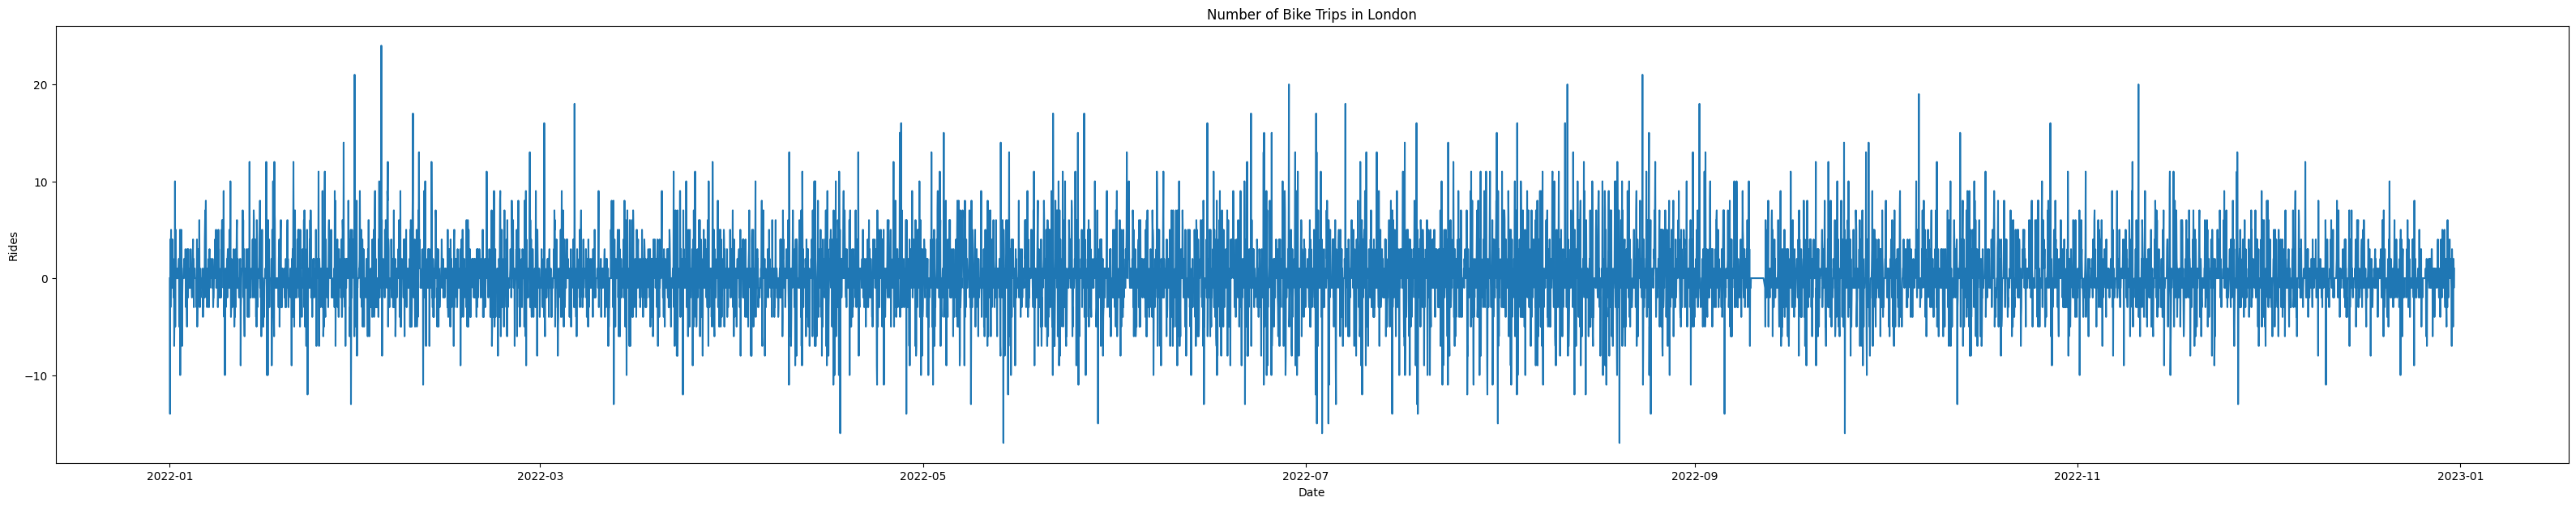

In [5]:
plt.figure(figsize=(40,7))
plt.title("Number of Bike Trips in London")
plt.xlabel('Date')
plt.ylabel('Rides')
plt.plot(df)
plt.show()

In [6]:
steps=-1
dataset_for_prediction= df.copy()

In [7]:
dataset_for_prediction['actual']=dataset_for_prediction['cnt'].shift(steps)

In [8]:
dataset_for_prediction.head(3)

,cnt,actual
StartDate,,
2022-01-01 00:00:00,0,-14.0
2022-01-01 01:00:00,-14,4.0
2022-01-01 02:00:00,4,-3.0


In [9]:
dataset_for_prediction=dataset_for_prediction.dropna()

In [10]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))

In [11]:
scaled_input = sc_in.fit_transform(dataset_for_prediction[['cnt']])

In [12]:
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

In [13]:
X.rename(columns={0:'cnt'}, inplace= True)

In [14]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [15]:
y.rename(columns={0:'nextday'}, inplace= True)
y.index=dataset_for_prediction.index
y.head(2)

,nextday
StartDate,
2022-01-01 00:00:00,0.073171
2022-01-01 01:00:00,0.512195


In [16]:
train_size=int(len(df) *0.7)
test_size = int(len(df)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

In [17]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [18]:
y_test=y['nextday'][:train_size].dropna()
test_adf(y_test, "Prediction")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Prediction


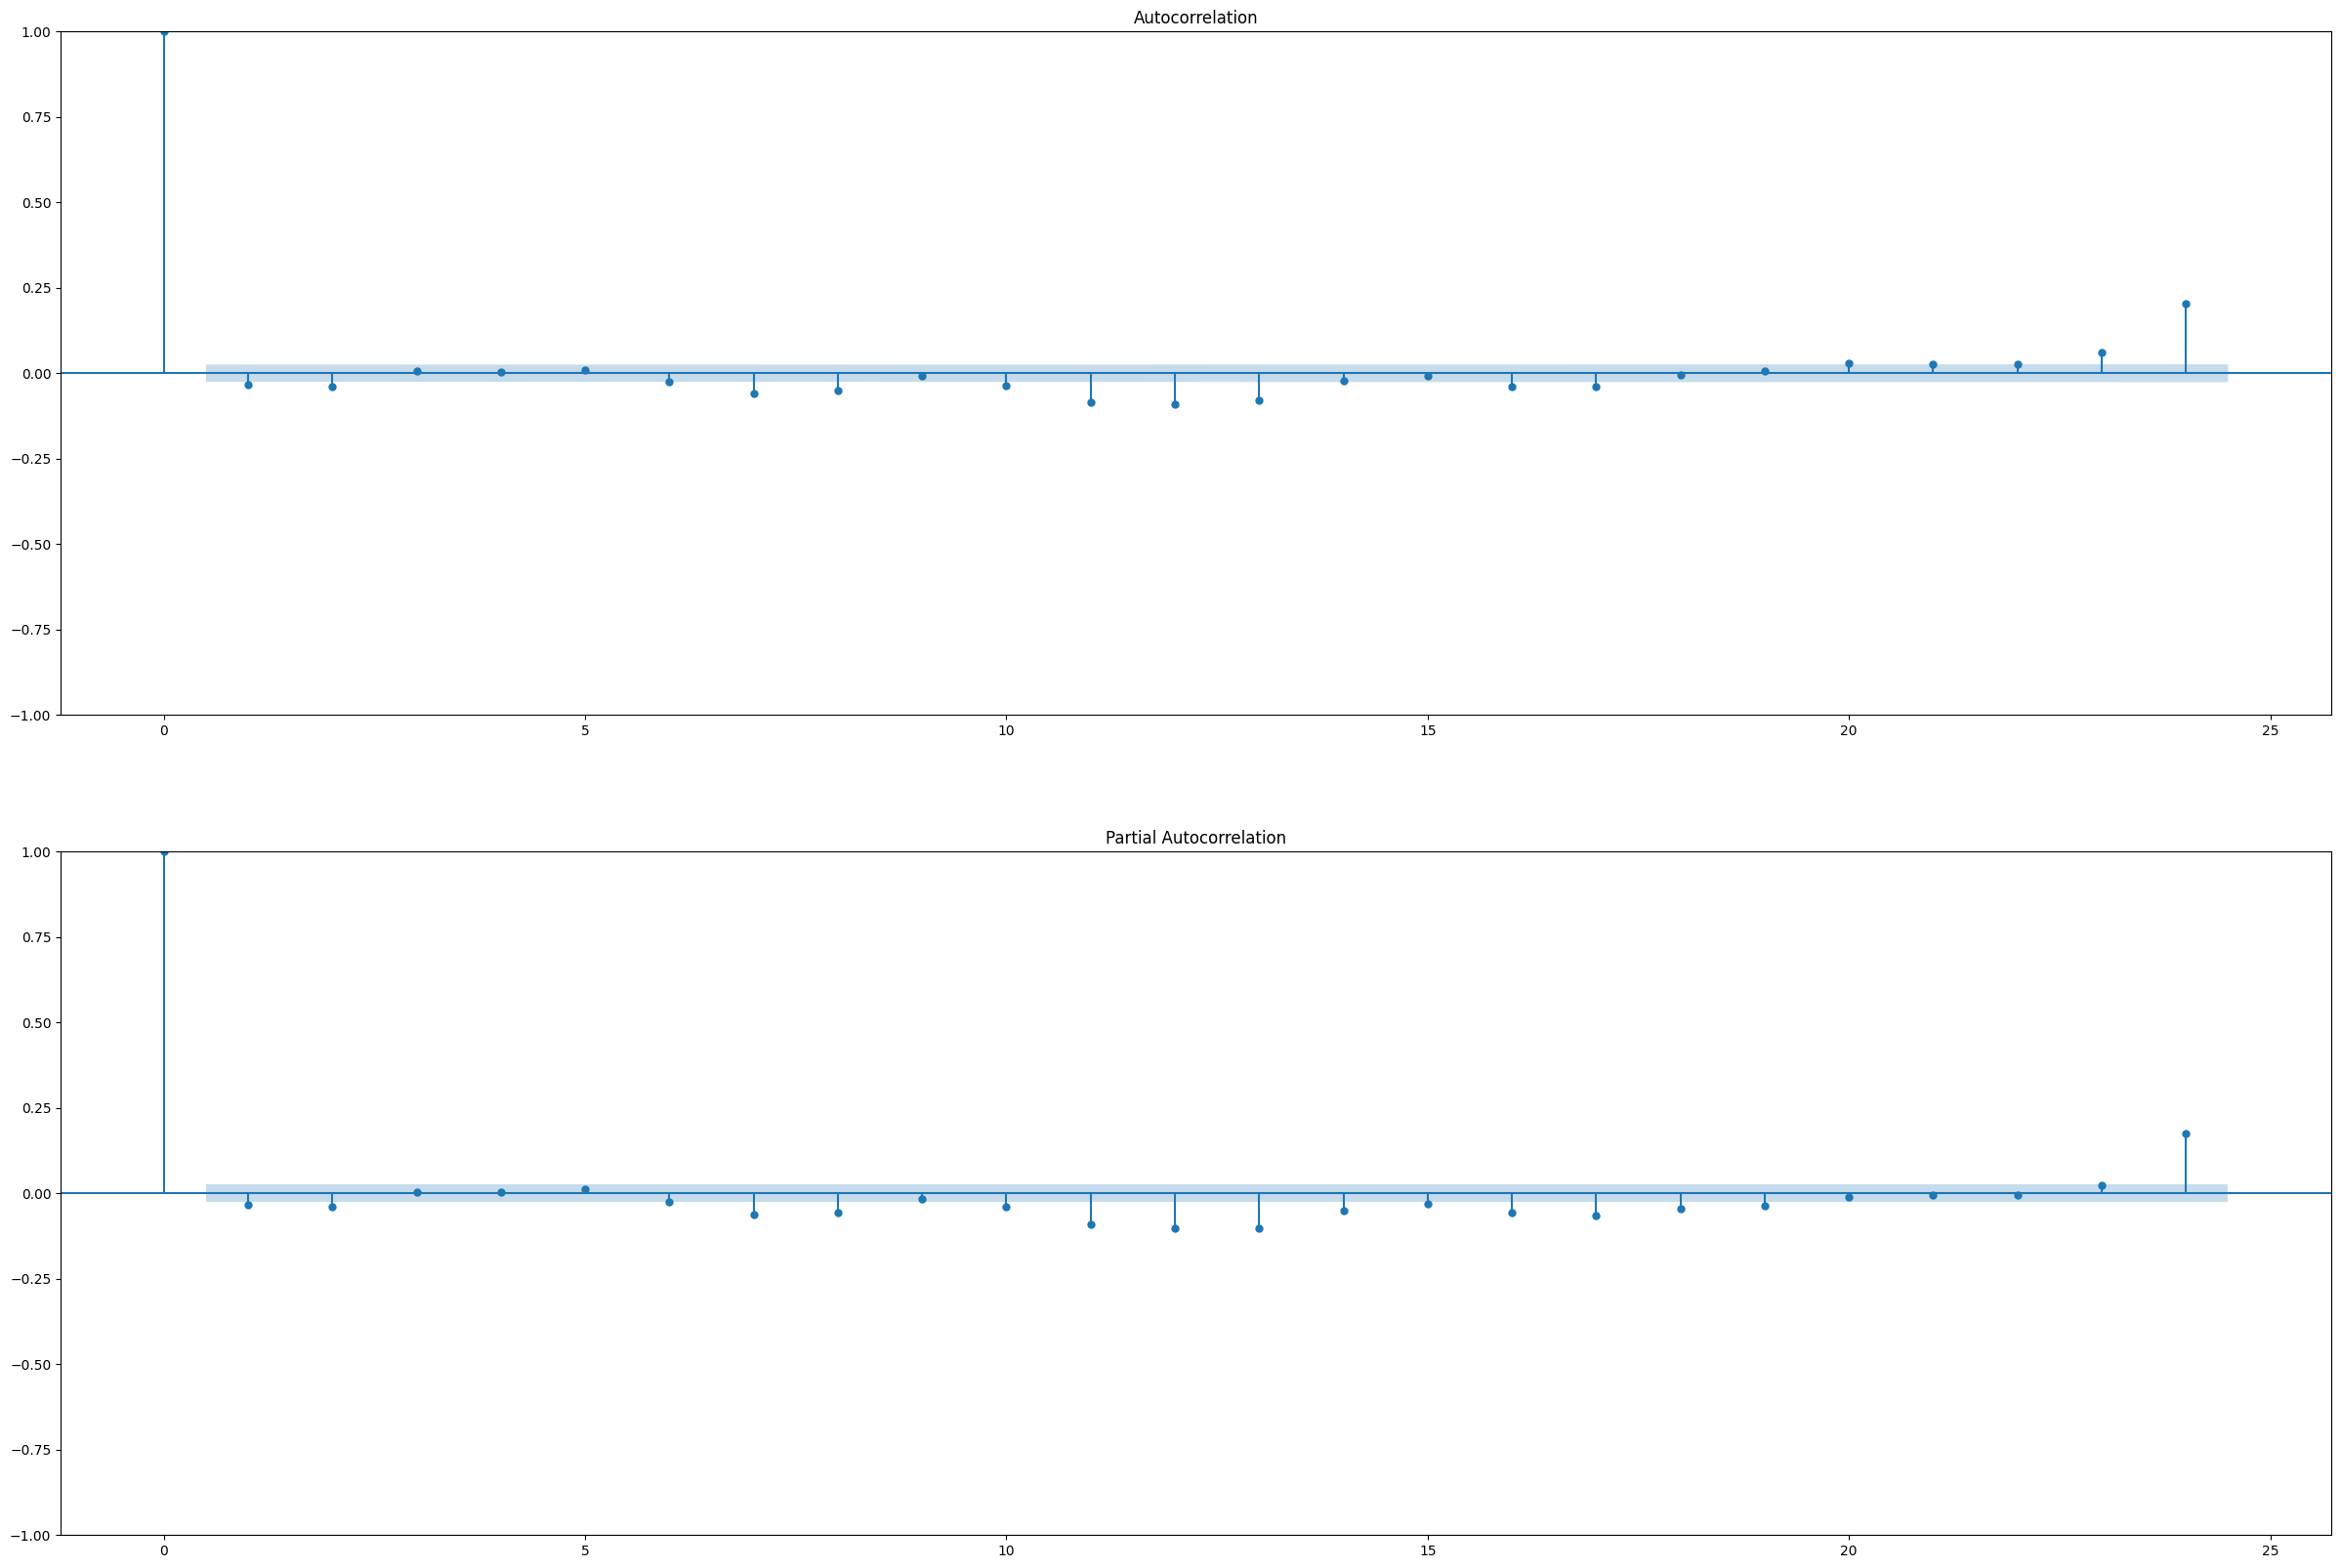

In [20]:
fig,ax= plt.subplots(2,1, figsize=(30,20))
fig=sm.tsa.graphics.plot_acf(y_test, lags=24, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=24, ax=ax[1])
plt.show()

In [19]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y,
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True,
 seasonal=True,
 m=24)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=68.20 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-7036.573, Time=0.35 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=-8904.621, Time=13.03 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=38.88 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-7038.572, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=-8760.232, Time=0.81 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=-8910.392, Time=50.47 sec


: 

: 

In [ ]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6078
Model:               SARIMAX(6, 1, 1)   Log Likelihood                5628.296
Date:                Mon, 04 Sep 2023   AIC                         -11238.593
Time:                        15:29:38   BIC                         -11178.183
Sample:                             0   HQIC                        -11217.628
                               - 6078                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.046e-06   3.89e-05     -0.053      0.958   -7.84e-05    7.43e-05
ar.L1         -0.0100      0.012     -0.841      0.401      -0.033       0.013
ar.L2          0.0159      0.012      1.281      0.200      -0.008       0.040
ar.L3          0.0217      0.013      1.675      0.094      -0.004       0.047
ar.L4         -0.0755      0.013     -5.665      0.000      -0.102      -0.049
ar.L5          0.0052      0.013      0.385      0.700      -0.021       0.032
ar.L6         -0.0660      0.014     -4.600      0.000      -0.094      -0.038
ma.L1         -0.9702      0.008   -127.063      0.000      -0.985      -0.955
sigma2         0.0093      0.000     78.029      0.000       0.009       0.010
===================================================================================
Ljung-Box (L1) (Q):                   6.62   Jarque-Bera (JB):              1853.90
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
train_y.shape , train_X.shape

((6078, 1), (6078, 1))

In [ ]:
train_X['index'] =train_y.index

In [ ]:
train_X = train_X.set_index('index')

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y, 
 exog=train_X,
 order=(6,1,1),
 enforce_invertibility=False, enforce_stationarity=False)

/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
results= model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.70234D-01    |proj g|=  7.04441D-02


 This problem is unconstrained.



At iterate    5    f= -8.73838D-01    |proj g|=  9.14433D-02

At iterate   10    f= -8.74641D-01    |proj g|=  3.34592D-02
  ys=-8.834E-02  -gs= 6.907E-03 BFGS update SKIPPED

At iterate   15    f= -9.18431D-01    |proj g|=  4.34210D-01

At iterate   20    f= -9.36420D-01    |proj g|=  2.54632D-01

At iterate   25    f= -9.42602D-01    |proj g|=  1.59811D-01

At iterate   30    f= -9.43939D-01    |proj g|=  1.31055D-02

At iterate   35    f= -9.44008D-01    |proj g|=  8.45680D-03

At iterate   40    f= -9.44033D-01    |proj g|=  1.84092D-02

At iterate   45    f= -9.44138D-01    |proj g|=  6.43070D-02


/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -9.44474D-01    |proj g|=  1.84868D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     76      1     1     0   1.849D-02  -9.445D-01
  F = -0.94447412864152391     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [ ]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X)

/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
forecast_1= results.forecast(steps=test_size-1, exog=test_X)

/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [ ]:
act

,nextday
timestamp,
2016-05-28 18:00:00,0.286387
2016-05-28 19:00:00,0.180280
2016-05-28 20:00:00,0.116412
2016-05-28 21:00:00,0.096056
2016-05-28 22:00:00,0.100382
...,...
2017-01-03 18:00:00,0.132570
2017-01-03 19:00:00,0.068830
2017-01-03 20:00:00,0.042875


In [ ]:
predictions=pd.DataFrame(predictions)

In [ ]:
predictions

,predicted_mean
timestamp,
2016-05-28 18:00:00,0.283402
2016-05-28 19:00:00,0.232754
2016-05-28 20:00:00,0.178252
2016-05-28 21:00:00,0.148760
2016-05-28 22:00:00,0.138856
...,...
2017-01-03 18:00:00,0.221931
2017-01-03 19:00:00,0.153920
2017-01-03 20:00:00,0.124996


In [ ]:
predictions['timestamp'] = act.index
predictions = predictions.set_index('timestamp')

<Axes: xlabel='timestamp'>

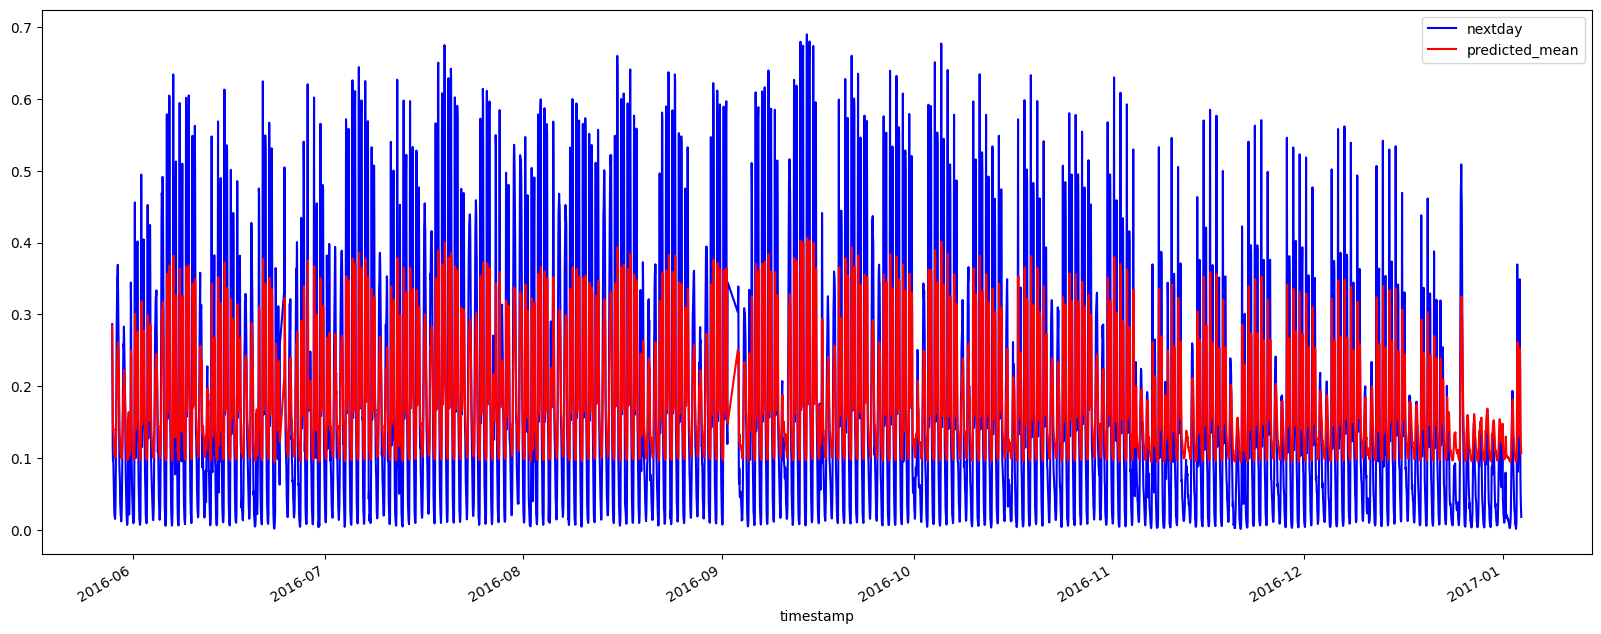

In [ ]:
act['nextday'].plot(figsize=(30,8), legend=True, color='blue')
predictions['predicted_mean'].plot(legend=True, color='red', figsize=(20,8))

In [ ]:
act_f = pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [ ]:
act_f

,nextday
timestamp,
2016-05-28 18:00:00,0.286387
2016-05-28 19:00:00,0.180280
2016-05-28 20:00:00,0.116412
2016-05-28 21:00:00,0.096056
2016-05-28 22:00:00,0.100382
...,...
2017-01-03 18:00:00,0.132570
2017-01-03 19:00:00,0.068830
2017-01-03 20:00:00,0.042875


In [ ]:
forecast_apple= pd.DataFrame(forecast_1)
forecast_apple.rename(columns={0:'Forecast'}, inplace=True)
forecast_apple.index=predictions.index

In [ ]:
forecast_apple

,predicted_mean
timestamp,
2016-05-28 18:00:00,0.283402
2016-05-28 19:00:00,0.232754
2016-05-28 20:00:00,0.178252
2016-05-28 21:00:00,0.148760
2016-05-28 22:00:00,0.138856
...,...
2017-01-03 18:00:00,0.221931
2017-01-03 19:00:00,0.153920
2017-01-03 20:00:00,0.124996


<Axes: xlabel='timestamp'>

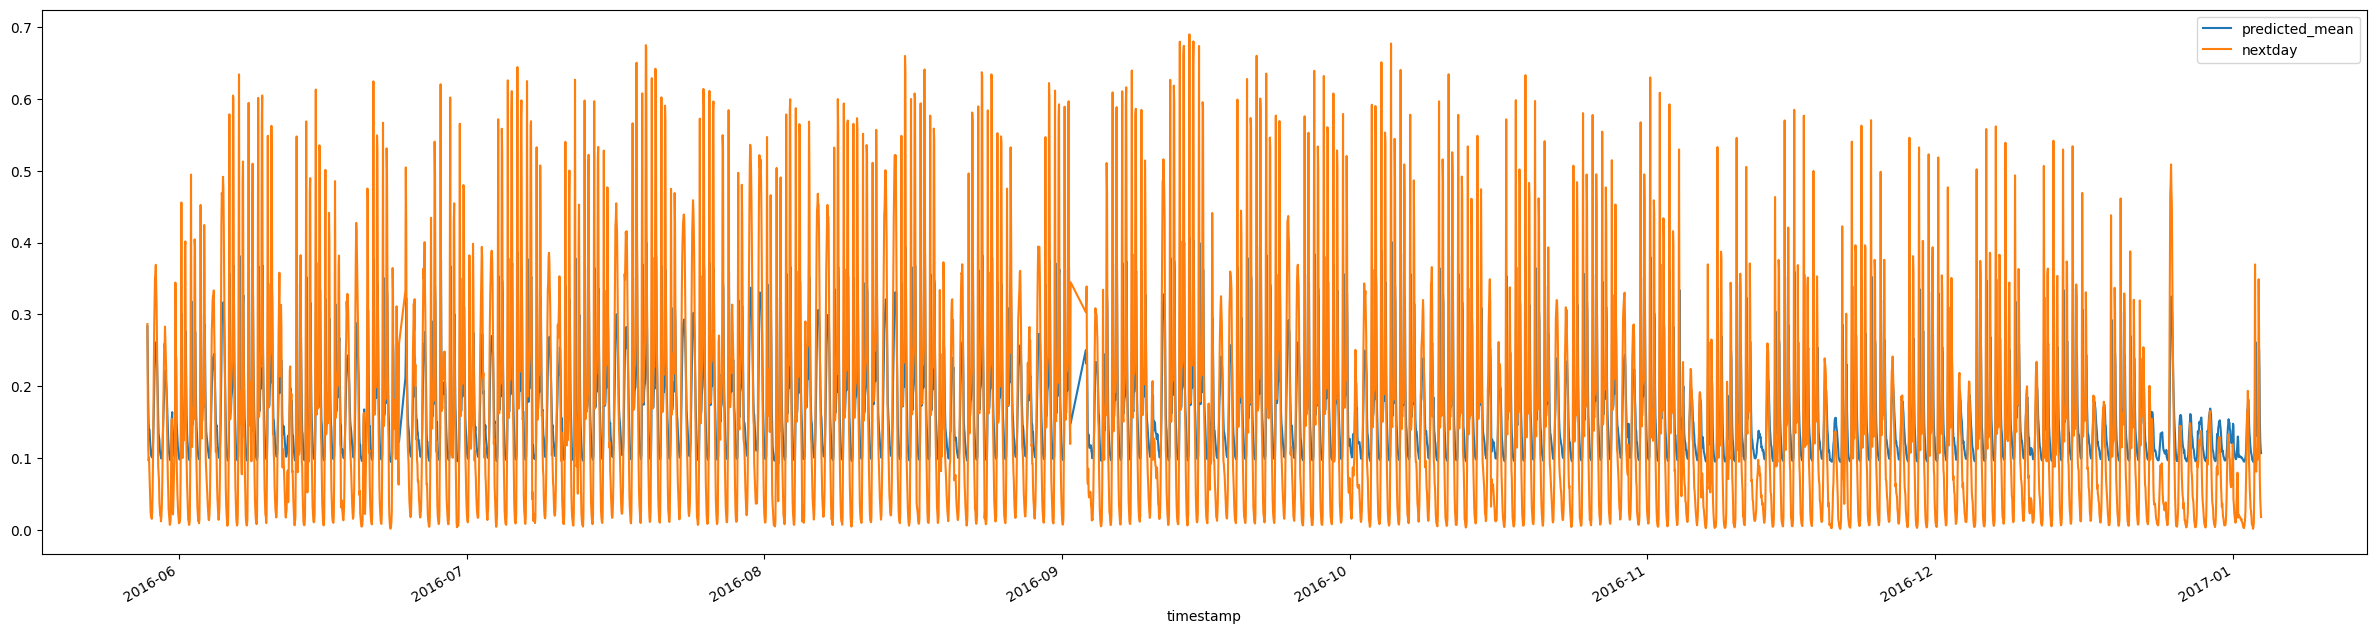

In [ ]:
forecast_apple['predicted_mean'].plot(legend=True,figsize=(30,8))
act_f['nextday'].plot(legend=True)

In [ ]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['predicted_mean'], act['nextday'])
error

0.10417024779044946

In [ ]:
trainPredict = sc_out.inverse_transform(predictions[['predicted_mean']])
testPredict = sc_out.inverse_transform(act[['nextday']])

In [ ]:
trainPredict = pd.DataFrame(trainPredict)
trainPredict.index = predictions.index 

testPredict = pd.DataFrame(testPredict)
testPredict.index = predictions.index 

<Axes: xlabel='timestamp'>

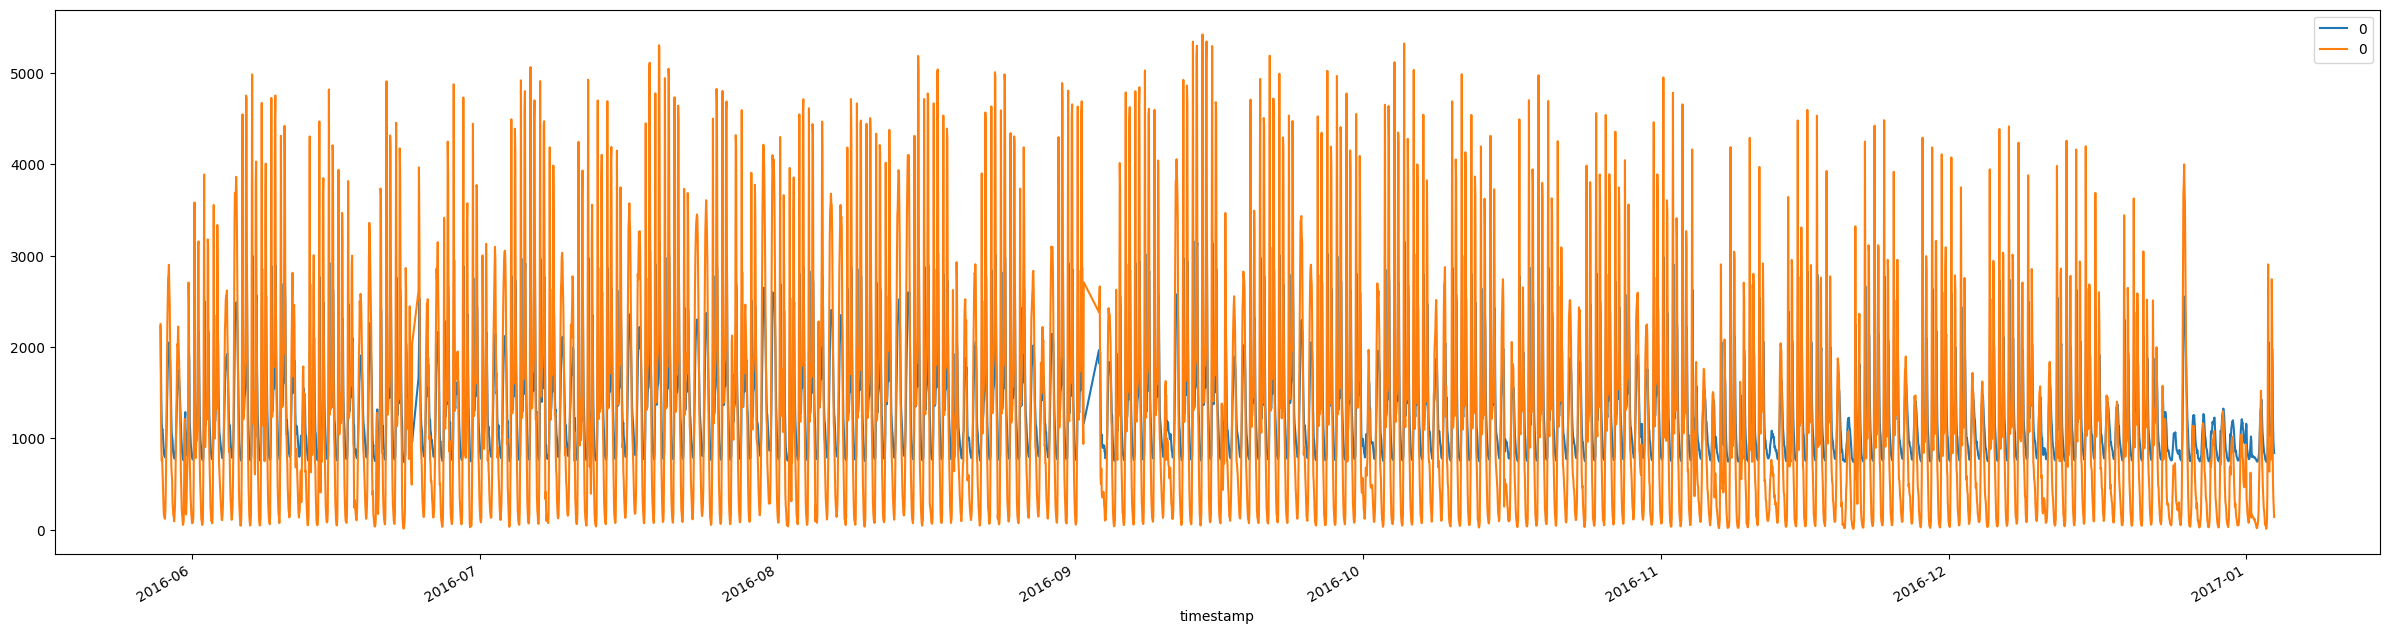

In [ ]:
trainPredict[0].plot(legend=True,figsize=(30,8))
testPredict[0].plot(legend=True,figsize=(30,8))